# Smart Meter Data Cleansing and Analysis
## Author: Alexander Van Roijen

Synopsis: In this notebook, I go through the process to generate the data and results highlighted [here](https://github.com/bogyshi/Data512/blob/master/finalProject/SmartEnergyResults.ipynb)

### The import statements below are necessary to run the rest of this notebook

In [2]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import datetime
import os
import matplotlib
from matplotlib.lines import Line2D
from sklearn import linear_model
from scipy.special import comb
from scipy import stats
import sys
sys.path.insert(1, '../data') # need this to import our data cleaning file
import sepData

### Lets initialize some constants for our analysis

In [3]:
numBlocks = 168 # In our data, we have 168 total blocks
dataDirec = '../data/pivotData/' # string specifying which directory our data is stored in


### The code below will create and clean data into the proper formats describe in the [writeup notebook](https://github.com/bogyshi/Data512/blob/master/finalProject/SmartEnergyResults.ipynb).
More details on how the functions work can be found in the according [sepData.py script](https://github.com/bogyshi/Data512/blob/master/finalProject/data/sepData.py)

In [ ]:
sepData.createHouseToTypeMappings() ## creates small seperate table "houseData.csv" that contains info on demographics on the households in our data
sepData.sepAllData() # seperates and pivots our data into the same blocks, but such that each row represents a households day worth of consumption
sepData.handleSpills() # some house ids have their measurements split amongst multiple groups, lets put these spilled-over houses into a seperate "spillSep.csv" file

### With the data cleaned, lets answer our first question!
## Are ToU customers responding to this pricing? In particular, do they consume more or less than their static pricing counterparts? Is this relationship significant?

In [6]:
counter = 1
allData=[pd.read_csv(os.path.join(dataDirec,'blockSpillsep.csv'))] ## remember our spillblocks we made? 
# of course not! it was done by the handleSpills function called earlier, check out the code in sepData.py to learn more!
while counter < numBlocks:
    vals = pd.read_csv(os.path.join(dataDirec,'block'+str(counter)+'sep.csv'))
    allData.append(vals)
    counter+=1
fullDF = pd.concat(allData,sort=True).set_index('LCLid') # lets aggregate this data into one large df
'''
The line below joins our full data with our seperate table indicating std or ToU. Then we can groupby the same metric
to gget the avg and standard deviations we need per time slice to determine signfigance and generate future plots
'''
avgAndStd=fullDF.join(justToU.set_index('LCLid')).groupby('stdorToU').agg([np.mean,np.std]).drop('Unnamed: 0',axis=1) ## drop column that counts data for our index

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [16]:
avgAndStd ## lets look at it and see if it works

00:00:00            00:30:00            01:00:00            \
              mean       std      mean       std      mean       std   
stdorToU                                                               
Std       0.201310  0.384248  0.179349  0.356839  0.159694  0.317455   
ToU       0.155759  0.208573  0.136889  0.186792  0.123535  0.170162   

          01:30:00            02:00:00               ...       22:00:00  \
              mean       std      mean       std     ...           mean   
stdorToU                                             ...                  
Std       0.145315  0.285296  0.134685  0.256440     ...       0.272779   
ToU       0.114487  0.158924  0.108778  0.153206     ...       0.254613   

                    22:30:00            23:00:00            23:30:00  \
               std      mean       std      mean       std      mean   
stdorToU                                                               
Std       0.314607  0.248106  0.296779  0.220291  0.279107  0.193274   
ToU       0.298575  0.233149  0.284386  0.205564  0.259819  0.178524   

                     Unnamed: 0               
               std         mean          std  
stdorToU                                      
Std       0.257746  5889.551838  3567.745628  
ToU       0.230929  6102.357400  3624.010778  

[2 rows x 98 columns]

In [96]:
## however, we also need sample sizes!
counts=fullDF.join(justToU.set_index('LCLid')).groupby('stdorToU').count().drop(['Date','Unnamed: 0'],axis=1)## dropping counts of unnecessary columns

/home/bdvr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### With the data generated, lets save it so we dont need to run this again, and then read it back in

In [17]:
avgAndStd.to_csv('../data/avg_and_stdev.csv') 
counts.to_csv('../data/countsPerStdAndToU.csv')

In [7]:
avgAndStd = pd.read_csv('../data/avg_and_stdev.csv')
counts= pd.read_csv('../data/countsPerStdAndToU.csv')

In [27]:
times = counts.columns[1:-2] # this gives us some nice labels for our future graphics

In [16]:
stdCounts = counts.values[0][1:49].astype(int) ## this is the number of rows under std pricing at each 30 minute interval 
touCounts = counts.values[1][1:49].astype(int) ## this is the number of rows under ToU pricing at each 30 minute interval
## gonna need this for all our pair wise t-tests

In [10]:
'''
Due to the format of how our data was saved, I concatenate the values together,
so the first 96 are std, and the following 96 are ToU
'''
stdAndToUValsComb = np.concatenate((avgAndStd.values[2][1:97],avgAndStd.values[3][1:97])) # 2 and 3 are the offset indexes for tou and std

### With our data read back in and formatted, lets parse it so we can visualize it

In [11]:
avgs=[] ## this will hold all our averages
stderrs=[] ## this will hold all our standard deviations
numVals = len(stdAndToUValsComb) ## this keeps track of how many values we are going to be parsing
counter=0

In [12]:
while(counter<numVals):
    '''
    every even numbered zero-indexed position is an avg
     
    every odd numbered zero-indexed position is the corresponding standard
    deviation for each time slice in the respective std or ToU pricing set
    '''
    avgs.append(stdAndToUValsComb[counter]) 
    stderrs.append(stdAndToUValsComb[counter+1]) 
    counter+=2
    

### Now we cast the data properly, and calculate the standard error
Recall, standard error is simple $\frac{\sigma}{\sqrt{n}}$ where n is the sample size

In [13]:
# casting data
# they are at different portions of 48 entries due to how we formed our data earlier
avgSTND = np.array(avgs[0:48]).astype(float)
avgTOU = np.array(avgs[48:]).astype(float)
stdSTND = np.array(stderrs[0:48]).astype(float)
stdTOU = np.array(stderrs[48:]).astype(float)

In [19]:
stdErrSTND = stdSTND/np.sqrt(stdCounts) # calculating standard error for std time slots
stdErrTOU = stdTOU/np.sqrt(touCounts) # calculating stanrad error for tou time slots

### Now lets visualize it!

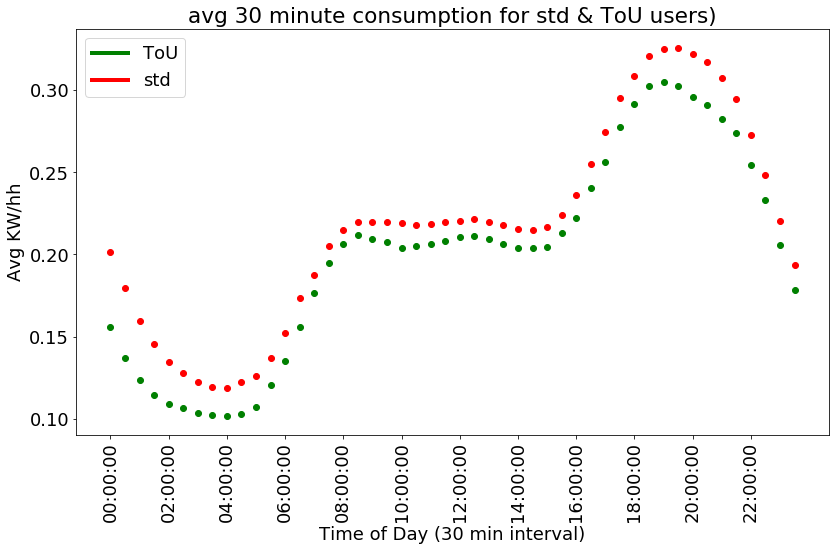

In [30]:
arnum = len(avgSTND) # how many data points are we plotting?
font = {'family' : 'normal',
        'size'   : 18} # lets make our text large enough
matplotlib.rc('font', **font) # setting font parameters
plt.figure(figsize=(12,8)) ## lets make hte figure big!

'''
matplotlib errorbars will be used to demonstrate the signifigance of our data
'''
plt.errorbar(np.arange(arnum), avgSTND, [stdErrSTND, stdErrSTND],fmt='.k', lw=1,markerfacecolor='red',ecolor='red',markeredgecolor='red',markersize='12')
plt.errorbar(np.arange(arnum), avgTOU, [stdErrTOU, stdErrTOU],fmt='.k',markerfacecolor='green', ecolor='green', lw=1,markeredgecolor='green',markersize='12')

plt.xlabel('Time of Day (30 min interval)')
plt.ylabel('Avg KW/hh')
plt.title('avg 30 minute consumption for std & ToU users)')
customLines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='red', lw=4)] # this is used to  make our custom legend
plt.legend(customLines, ['ToU','std'],loc='upper left') # look here for more info https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
plt.xticks(np.arange(0,48,4),times[np.arange(0,48,4)],rotation='vertical') # lets add some labels that make sense!
plt.tight_layout() # lets make sure when we save it, that there isnt too much white space
plt.savefig('../images/stdvstouAll.jpg',quality=95) # finally, we save the high quality result to file

## Observations
Clearly, there are some large differences, and the error bars are so small it must be statistically significant, but lets make sure!

In [35]:
def calcTVal(avg1,avg2,std1,std2,count1,count2):
    '''
    This function returns the t-value for the difference between two means assuming unequal variances
    You can read more here https://en.wikipedia.org/wiki/Welch%27s_t-test
    '''
    return (avg1-avg2)/np.sqrt(((std1**2)/count1)+((std2**2)/count2))

In [36]:
def calcDF(std1,std2,count1,count2):
    '''
    We need to calculate the degrees of freedom for our welch test to determine what kind of distribution we are following
    '''
    top = (std1**2/count1 + std2**2/count2)**2
    botPart1 = (std1**2/count1)**2/(count1-1)
    botPart2 = (std2**2/count2)**2/(count2-1)
    return top/(botPart1+botPart2)

In [37]:
## we assume unequal varinaces. Why? 
## Because I anticipate that users who are under dynamic ToU are much morelikely to vary in their decisions
counter = 0
pvals = []
avgDiffs = []
while(counter < len(avgSTND)):
    # get necessary information
    stdavgVal = avgSTND[counter]
    touavgVal = avgTOU[counter]
    stdsdVal = stdSTND[counter]
    tousdVal = stdTOU[counter]
    stdcountVal = stdCounts[counter]
    toucountVal = touCounts[counter]
    # pass to functions
    tVal = calcTVal(stdavgVal,touavgVal,stdsdVal,tousdVal,stdcountVal,toucountVal)
    df = calcDF(stdsdVal,tousdVal,stdcountVal,toucountVal)
    # calc pvalue, could be done using a table, which is what the below does
    pval = stats.t.sf(np.abs(tVal), int(df))*2 # read more here https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html
    pvals.append(pval) # append to list
    avgDiffs.append(stdavgVal-touavgVal) # record the difference
    counter+=1 # on to the next
pvals = np.array(pvals)
avgDiffs = np.array(avgDiffs)

In [38]:
for t,p,avg in zip(times,pvals,avgDiffs):
    print(f"P-value at time {t} is : {p} with avg diff {avg}")

P-value at time 00:00:00 is : 0.0 with avg diff 0.04555165226852256
P-value at time 00:30:00 is : 0.0 with avg diff 0.04245928815215902
P-value at time 01:00:00 is : 0.0 with avg diff 0.03615918171400587
P-value at time 01:30:00 is : 0.0 with avg diff 0.030827801596509913
P-value at time 02:00:00 is : 0.0 with avg diff 0.025907109650552942
P-value at time 02:30:00 is : 0.0 with avg diff 0.02129954065926093
P-value at time 03:00:00 is : 0.0 with avg diff 0.018909873579256165
P-value at time 03:30:00 is : 0.0 with avg diff 0.016585453080872545
P-value at time 04:00:00 is : 0.0 with avg diff 0.01689951477540834
P-value at time 04:30:00 is : 0.0 with avg diff 0.018886259438851347
P-value at time 05:00:00 is : 0.0 with avg diff 0.01849406183654831
P-value at time 05:30:00 is : 0.0 with avg diff 0.016025233044465056
P-value at time 06:00:00 is : 0.0 with avg diff 0.016565370767034904
P-value at time 06:30:00 is : 0.0 with avg diff 0.017355926159962926
P-value at time 07:00:00 is : 1.06474275

### Clearly, there is strong significance here
Now, what about our second question?
##  If this relationship is significant, what kind of savings do we get when switching to ToU? Where do we see maximum savings? Do we reduce peak load?

In [39]:
stdAvgDlyConsumption = np.sum(avgSTND)# how much consumption per day for the average std house?
touAvgDlyConsumption = np.sum(avgTOU) # how about for tou houses?
avgperyear = np.sum((avgSTND-avgTOU)*365 ) # now what does that mean for the year?
print(stdAvgDlyConsumption)
print(touAvgDlyConsumption)
print(avgperyear)

10.427517011470306
9.582110801646738
308.57326658560214


### Thats a total of 308.57 kwh savings per year for each household!

### What about peak load?

In [40]:
peakTimes = times[36:41]
peakTimes # these are the times of greatest draw on the grid

Index(['18:00:00', '18:30:00', '19:00:00', '19:30:00', '20:00:00'], dtype='object')

In [41]:
peakIndexes=np.arange(36,41,1)
(avgDiffs[peakIndexes])/avgSTND[peakIndexes] # this shows us the percentage difference between our groups

array([0.05539357, 0.05764366, 0.06106602, 0.07081284, 0.08135982])

### As shown in the results notebook, we can see that from 6 to 6:30 p.m., we see a reduction of about 5.5 % when switching to a ToU household.

### But where do we see the maximum difference?

In [44]:
print(np.max(avgDiffs)/avgSTND[avgDiffs==np.max(avgDiffs)]) # this is the percentage shift
print(times[avgDiffs==np.max(avgDiffs)][0]) # this is the time where it happens

[0.22627564]
00:00:00


### Thats quite the drop! How much was each one at respectively?

In [66]:
print(avgSTND[0])# this is the std usage at midnight
print(avgTOU[0])# this is the tou usage at midnight

0.20131045576132586
0.1557588034928033


## Great! Now We can address our final research question "Can we model future consumption using only past consumption as a signal?"

If you recall, we will be using SINDy to achieve this task! this is where the following functions come into play

__Warning, the code below may not make too much sense unless you are familiar with SINDy__

To better familiarize yourself with the code below, feel free to read over my own paper [here](https://github.com/bogyshi/AMATH563/blob/master/hw2/hw2Report.pdf)

In [20]:
'''
These functions below are for formatting our data into a form acceptable for SINDy processing
'''

def windowData(houseVals,windowSize=2):
    '''
    This function takes a blocks data, and the window size, and simply creates data in the form of 
    Inputs:
    [[C@(t-windowSize), C@(t-windowSize+1),  C@(t-windowSize+2) ...  C@(t-1)],
     [C@(t-windowSize+1, C@(t-windowSize+2),  C@(t-windowSize+3) ...  C@(t)]
     ...
     ]
    Outputs:
    [[C@(t)],
     [C@(t+1)]
     ...
     ]
    This creates a matrix such that each row represents a window of consumption (C) leading up to the next level of consumption
    '''
    counter = 2
    ins=[]
    outs=[]
    j=0
    while(counter<houseVals.shape[0]):
        temparr = []
        j=windowSize
        while(j>0):
            temparr.append(houseVals[counter-j])
            j-=1
        ins.append(temparr)
        outs.append(houseVals[counter])
        counter+=1
    return np.array(ins),np.array(outs).reshape(-1,1)
def createWindowData(blockRange,windowSize,save=False):
    '''
    This function lets you state how many blocks of information you want to use, 
    as well as the window of data you want to use, whether that is simply 1,2,3 or even a whole days worth of 48 timesteps
    '''
    skipRows = np.setdiff1d(temp1.index,temp1.dropna().index) # are there any rows with null values? if so, lets make sure to skip them
    counter = 0
    inputs=[]
    outputs=np.array([])
    init=False
    houseData = pd.read_csv('../data/houseData.csv',header=0,encoding='ISO-8859-1') # lets get  house ids and make sure they are what we want
    for h in blockRange:
        houseReadings = pd.read_csv('../data/pivotData/block'+str(h)+'sep.csv',header=0,encoding='ISO-8859-1').dropna() # get the house data and drop null rows
        for x in houseData.values: # for each house, lets get their values
            oneHouseReadings = (houseReadings.iloc[(temp1.LCLid==x[0]).values]).values[:,2:] # this is one houses data
            counter+=1
            if(oneHouseReadings.shape[0]!=0): # if the dataset is empty, dont try to process it!
                x,y=windowData(oneHouseReadings.flatten(),windowSize) # lets get our inputs and outputs
                if(init): # if we havent initialized, dont try to append data
                    inputs=np.concatenate((inputs,x)) # append new  inputs to our current number of input rows
                    outputs = np.concatenate((outputs,y)) # same thing but for outputs
                else: # our inputs and outputs are empty, lets set initialize then
                    inputs = x
                    outputs = y
                    init = True # dont need to do this again
    if(save):# if we want to save after generating a lot of data, lets do that!
        np.save('../data/block'+str(blockRange[0])+'-'+str(blockRange[-1])+'wdsz'+str(windowSize)+'INS.npy',inputs) # saving inputs
        np.save('../data/block'+str(blockRange[0])+'-'+str(blockRange[-1])+'wdsz'+str(windowSize)+'OUTS.npy',outputs) # saving outputs
    return inputs,outputs # return data just in case

In [21]:
'''
The functions below are meant to generate coefficients, 
future smart meter readings, and then present a graphic 
to highlight its abilities.
'''
def plotMyAttempt(ogv,myv,time,startpos,duration,timeString,title = 'prediction of consumption over time',ylab='kwh/hh',
                  legendData=['original', 'my guess'],bigfig = False,saveFig=False,saveName='../images/tempPic.jpg'):
    if(bigfig):
        plt.figure(figsize=(10,8)) # lets make the picture bigger!
    repFactor = int(duration / 48) # for future versions, meant for forecasting over day long periods
    part1Times = timeString[np.arange(startpos,48)] # starting from the initial time 'start pos' to the end of the day
    part2Times = timeString[np.arange(0,(duration+startpos)%48)] # starting from the beginning of the day to the 'start pos' -1 time slot
    timeOrder = np.concatenate((part1Times,part2Times),axis=None) # now lets get a proper x axis
    timeOrder = timeOrder[np.arange(0,48,4)] # give the x axis labels
    plt.clf() # clear any residual figures
    plt.plot(ogv,'--') # original values, or what we want to predict
    plt.plot(myv, 'o') # my predicted values, what we hope is similar to ogv

    plt.title(title) # add custom title
    plt.ylabel(ylab) # add custom ylab, originall kilowatt hours per half hour (kwh/hh)
    plt.xlabel('time of day') #
    plt.xticks(np.arange(0,48,4),timeOrder,rotation='vertical')
    plt.tight_layout()

    plt.legend(legendData, loc='upper left')
    if(saveFig):
        plt.savefig(saveName,quality=95) # saved if wanted
    plt.show()

def solveLasso(A,b,penalty,iters=0): 
    '''
    solves lasso regression with a penalthy and maximum iterations specified
    '''
    if(iters>0):
        clf = linear_model.Lasso(alpha=penalty,max_iter=iters)
    else:
        clf = linear_model.Lasso(alpha=penalty)
    clf.fit(A,b)
    return (clf.coef_)


def getLargeLib(ys,single=False):
    '''
    This currently creates a large library depending on the window size of the data
    transformations include y, sqrt(y), y squared, y cubed, all pairwise multiplications,
    all pairwise multiplicaitons sined, three way multiplications
    '''
    numYs = ys.shape[1]
    y1 = ys[:,0]
    y2 = ys[:,1]
    ycounter = 0 
    if(single):
        numRows=1
    else:
        numRows = len(ys)
    numCols = int(1+5*numYs+2*comb(numYs,2)+comb(numYs,3))
    colCounter = 0
    lib = np.ones([numRows,numCols]) # constant / intercept
    lib[:,0]#nothing as its our constant column
    colCounter+=1
    while(ycounter<numYs): # y
        lib[:,colCounter] = ys[:,ycounter]
        ycounter+=1
        colCounter+=1
    ycounter=0
    while(ycounter<numYs): # sqrt(y)
        lib[:,colCounter] = np.sqrt(ys[:,ycounter])
        ycounter+=1
        colCounter+=1
    ycounter=0
    while(ycounter<numYs): # sin(y)
        lib[:,colCounter] = np.sin(ys[:,ycounter])
        ycounter+=1
        colCounter+=1
    ycounter=0
    while(ycounter<numYs): # y^2
        lib[:,colCounter] = ys[:,ycounter]**2
        ycounter+=1
        colCounter+=1
    ycounter=0
    while(ycounter<numYs): # y^3
        lib[:,colCounter] = ys[:,ycounter]**3
        ycounter+=1
        colCounter+=1
    ycounter=0
    j=0
    while(ycounter<numYs): # y_i * y_j
        j=ycounter+1
        while(j<numYs):
            lib[:,colCounter]=(ys[:,ycounter]*ys[:,j])
            colCounter+=1
            j+=1
        ycounter+=1
    ycounter=0
    j=0
    while(ycounter<numYs):# sin(y_i*y_j)
        j=ycounter+1
        while(j<numYs):
            lib[:,colCounter]=np.sin(ys[:,ycounter]*ys[:,j])
            colCounter+=1
            j+=1
        ycounter+=1
    ycounter=0
    j=0
    k=0
    while(ycounter<numYs): #(y_counter * y_j * y_k) # only works with at least 3 signals
        j=ycounter+1
        while(j<numYs):
            k = j+1
            while(k<numYs):
                lib[:,colCounter]=ys[:,ycounter]*ys[:,j]*ys[:,k]
                colCounter+=1
                k+=1
            j+=1
        ycounter+=1
    
    return lib

def marchForward(time,coefPower, initPoint,windowSize,filter=None,doLargeLib=False):
    '''
    This function, given an initial starting point, marches our predictions forward, and uses
    each prediction as a new input to predicting the next step, while pushing all other points back.
    
    time is the duration, or how many time steps we seek to predict into the future
    
    coefPower are the coefficient values determined by the lasso regression 
    
    initPoint is our initial input to be used to start our predictions
    
    windowSize is how many datapoints are in our input
    
    filter is an array the size of the coefPower that lets users specify particular parameters to zero out
    
    doLargeLib is a boolean to handle for legacy code, will be updated
    
    
    It returns the series of predictions over a specified time frame
    '''
    counter = 0
    duration=len(time)
    debug = False
    myReading = initPoint
    myGuesses = np.zeros([duration,2])
    while(counter<duration):
        i=0

        if(doLargeLib): # we used to have an older library creation function, so this legacy code remains 
            toCoefPower= getLargeLib(myReading.reshape(1,-1),True) # We need to transform our input
        else:
            toCoefPower= getLibrary(myReading.reshape(1,-1),True)

        if(filter is not None): # can use a custom filter to set particular coefficents to zero, useful when values explode
            tfilter = np.array(filter,dtype=bool)
            toCoefPower = (toCoefSS.T[tfilter]).T

        myNewReading = toCoefPower.dot(coefPower)[0]
        while(i<windowSize-1):
            myReading[i]=myReading[i+1]
            i+=1
        myReading[-1]=myNewReading
        myGuesses[counter] = [time[counter],myNewReading]
        counter+=1
    if(debug):
        print(toCoefPower.shape)
    return myGuesses

### With the functions detailed and explained, lets use them to try and predict future energy usage!
In particular, lets try a window size of 2 hours, lets see if transformation on 2 hours worth of signal can give us enough data to make something meaningful!

Furthermore, lets only use one blocks worth of data and keep things simple.

In [ ]:
blocksToUse = [1] # how many blocks from our pivotdata should we use? For this example, just block 1.csv
wndwSize = 4 # how large of a window do we want? For this example, 4, or two hours
createWindowData(blocksToUse,wndwSize,True) ## this will create and save our data for a window of size 4 30 min intervals, or two hours

### With our data prepared, lets load it, and try to solve it for some coefficients with the following parameters

$\lambda = 0.0001$

$maxIter$ = None

In [24]:
fourdinputs = np.load('../data/block1-1wdsz4INS.npy')
fourdoutputs = np.load('../data/block1-1wdsz4OUTS.npy')
fourlib = getLargeLib(fourdinputs) # this gets us a giant transformation library
fourCoef = solveLasso(fourlib,fourdoutputs,0.01) # this will solve and return our coefficents

In [25]:
fourCoef #what do our coefficeints look like?

array([ 0.        ,  0.00443798,  0.0444944 ,  0.00306371,  0.57395031,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.018471  ,  0.00529353,  0.        ,  0.        ,  0.        ,
        0.00781377,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ])

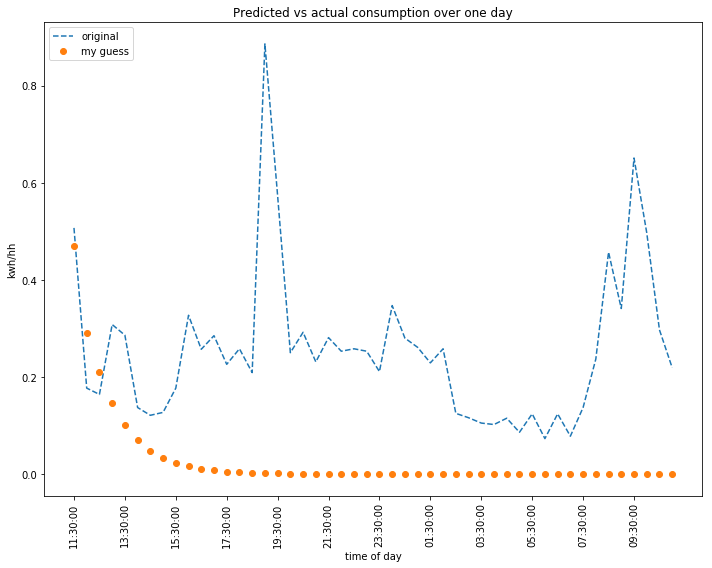

In [29]:
duration = 48*1 # lets go for one day, or 48 half hour intervals
timeReplace=np.arange(duration)
startpos = 23 # what timepoint from the initial output should we start from?
fourRes = marchForward(timeReplace,fourCoef,np.copy(fourdinputs[startpos]),4,None,True)
plotMyAttempt(fourdoutputs[startpos:startpos+duration,0],fourRes[:,1],timeReplace,startpos,duration,times,
              'Predicted vs actual consumption over one day',bigfig=True,saveFig=True,saveName='../images/4dwindowRes.jpg')

### And thats it! we have our predictions plotted over time!

# Summary & Results
You can find a more elaborate discussion of results, including motivation, and previous works in [this notebook](https://www.google.com)